# Visualizing Stack Overflow Data in Python

In this notebook, we visualize posts on Stack Overflow from the first 14 days of September 2017. The data was compiled from searches on the [Stack Exchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new). Location information was added using the [Google Maps API](https://developers.google.com/maps/).

<div id="contents"></div>
## Table of Contents
1. [Load the Data](#load)
1. [Visualize Completeness](#completeness)
1. [Visualize Time](#time)
1. [Visualize Tags](#tags)
1. [Explore Text](#explore)
1. [Plot Place](#place)
1. [Plot Connections](#network)
1. [Conclusion](#conclusion)

Make sure to go through the first two sections (data and completeness) first. The other sections can be done out of order.

## Load Libraries
This cell contains all the libraries which are necessary for this notebook

In [1]:
# General purpose libraries
# A nice library for reading in csv data
import pandas as pd
# A library which most visualization libraries in Python are built on.
# We will start by using it to make some plots with pandas
%matplotlib inline
import matplotlib.pyplot as plt
# A library for doing math
import numpy as np
# A library for turning unicode fields into ASCII fields
import unicodedata
# a regex library
import re
# a class which makes counting the number of times something occurs in a list easier
from collections import Counter
# to import the data from google sheets
import requests
from io import StringIO

# some functions for displaying html in a notebook
from IPython.core.display import display, HTML

# A library to visualize holes in a dataset
import missingno as msno

# Libraries for Word Trees
# lets us use graphviz in python
from pydotplus import graphviz
# to display the final Image
from IPython.display import Image

# Libraries interactive charts
from bokeh.io import output_notebook
# display interactive charts inline
output_notebook()
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColorBar, LinearColorMapper, FixedTicker, ColumnDataSource, LogColorMapper
# to make patches into glyphs and treat counties and states differently
from bokeh.models.glyphs import Patches

Loading BokehJS ...

The following import is a pair of shape files we use for making maps. If you haven't downloaded these shape files previously, you will need to run `bokeh.sampledata.download()`. If you don't want to download these files, you will miss out on part of the mapping section, but otherwise the notebook will be unaffected.

In [2]:
# import bokeh.sampledata as sampledata
# sampledata.download()

# shape files for US counties
from bokeh.sampledata.us_counties import data as counties
# shape files for US states
from bokeh.sampledata import us_states as us_states_data

<div id="load"></div>
## Load the Data
*[Table of Contents](#contents)*

In [7]:
url = 'https://docs.google.com/spreadsheets/d/1Uz3F_jCNHTo84k1jVQGGa_n_ZQpBUNKyI0ij6Bc3AlM/export?format=csv'
# r = requests.get(url)
# data = r.content

# load the data
posts = pd.read_csv(url)
posts.head()

,PostId,Score,PostType,CreationDate,Title,UserId,Reputation,Location,Tags,QuestionId
0,46009270,0,Question,2017-09-02 0:00:07,Android: AlarmManager running every 24h - is i...,8281994.0,173.0,Germany,<android><alarmmanager>,NaN
1,46009271,0,Answer,2017-09-02 0:00:22,NaN,1812182.0,1641.0,"Canary Islands, Spain",NaN,45947723.0
2,46009275,1,Answer,2017-09-02 0:00:42,NaN,8549754.0,21.0,NaN,NaN,46007409.0
3,46009276,1,Answer,2017-09-02 0:00:47,NaN,2478398.0,793.0,NaN,NaN,46009169.0
4,46009273,0,Answer,2017-09-02 0:00:36,NaN,5465303.0,87.0,"Ann Arbor, MI, United States",NaN,46008023.0


## Columns
What do all these columns mean?
1. PostId = the id in Stack Overflow's database of this post
1. Score = the score given to the post by people voting up and down on it
1. PostType = What type of post is this?
1. CreationData = When was this post posted?
1. Title = The text in the title of the post
1. UserId = The id of the user who posted in the Stack Overflow database
1. Reputation = The reputaiton of the user who posted
1. Location = The location the user put down as their home on their profile
1. Tags = Tags which are associated with this post
1. QuestionId = The question this post is linked to

Let us convert CreationDate to a datetime type

In [8]:
posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])

<div id="completeness"></div>
## Visualizing Completeness
*[Table of Contents](#contents)*

I'd like to know how complete our data is, so let's look at which fields have null values for the answers and questions using [missingno](https://github.com/ResidentMario/missingno).

Black indicates that the data is present while white indicates that it is missing. The column on the far right is meant to show a chart of how many variables each data point has. It is a bit hard to see on a dataset this large, but if you change the command to `msno.matrix(posts.sample(100))` it will make more sense.

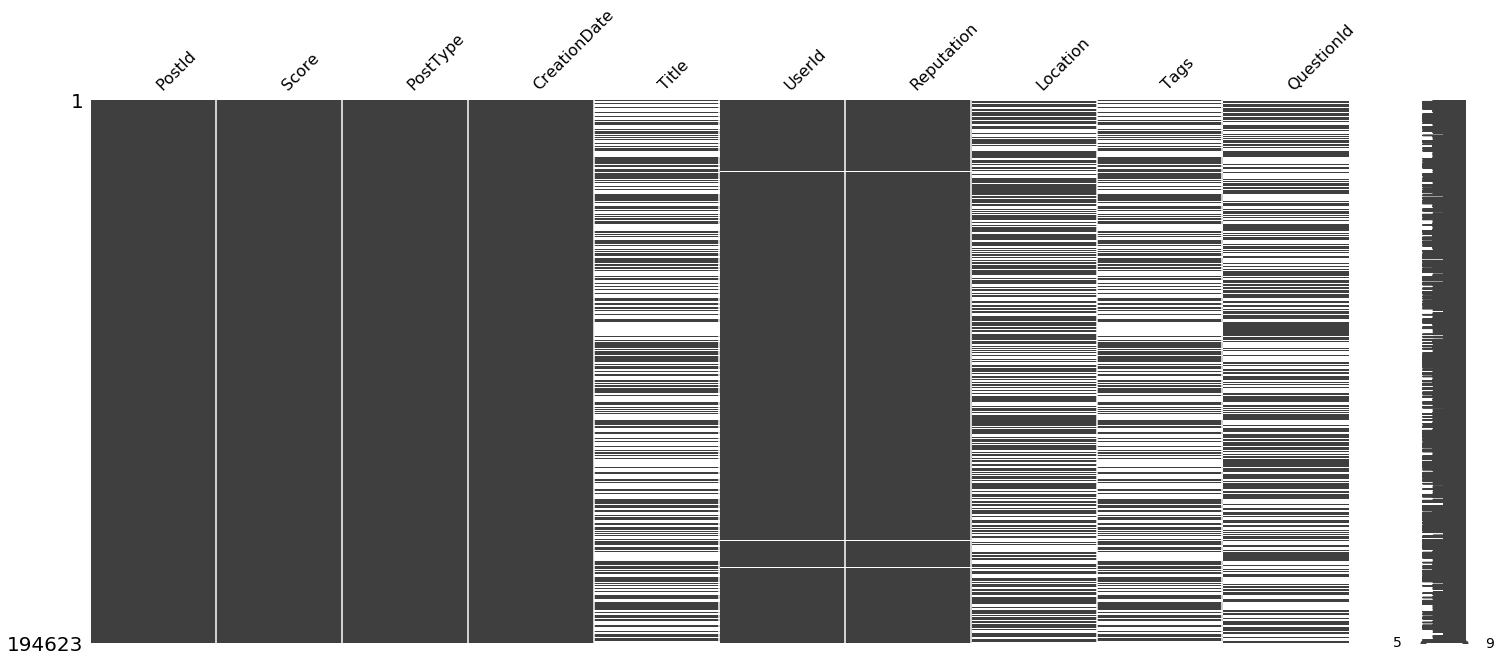

In [12]:
msno.matrix(posts)

Is there any correlation between when columns are null? Why don't we have a single row which is complete in all 10 columns?

Missingno has a lot of ways of visualizing data completeness. One of them is to see the correlation in missing-ness between fields. It does this by generating a heatmap where blue indicates two fields tend to go missing together and red indicates two fields tend to be mutually exclusive. Fields which are always present are excluded from the heatmap, and correlations below 0.1 are grayed out.

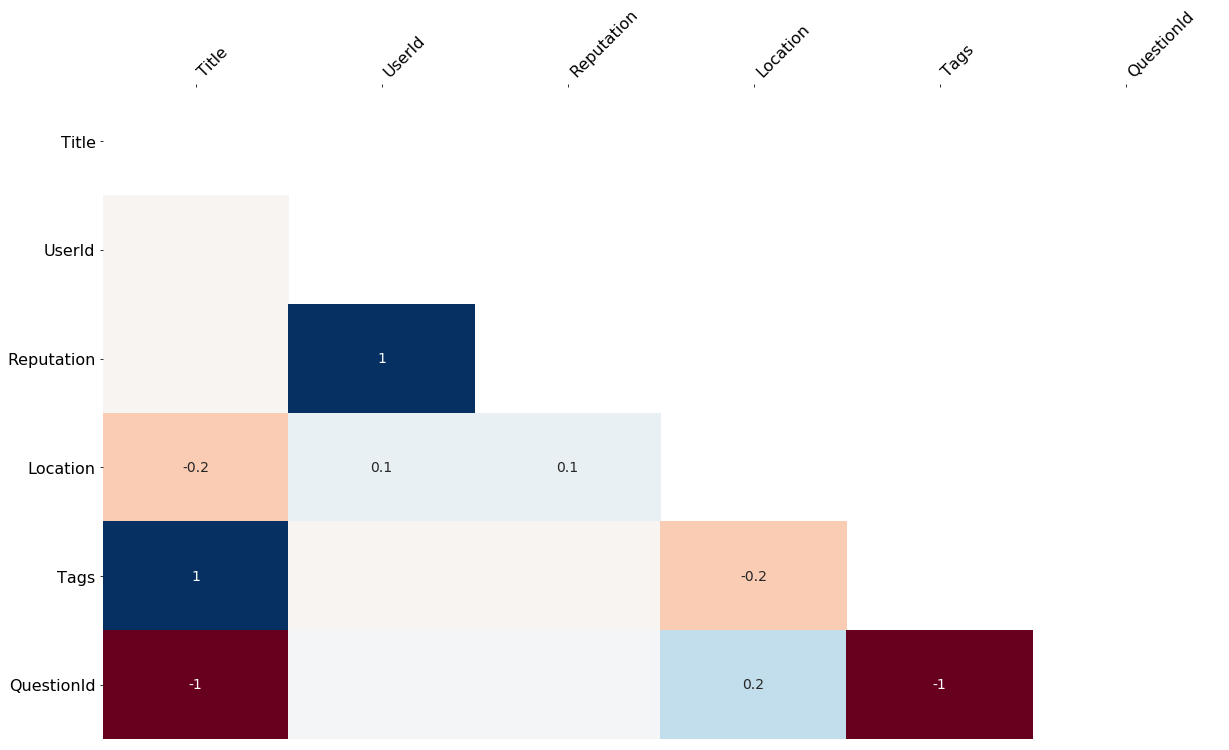

In [13]:
msno.heatmap(posts)

Notice that posts with title information always have tag information and never have a question id.

I wonder if these groups make up different types of posts. Let's investigate which post types we have.

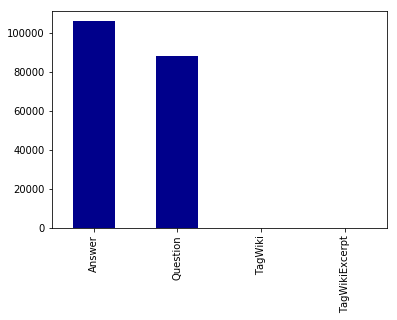

In [14]:
post_type_counts = posts['PostType'].value_counts()
post_type_counts.plot(kind='bar', color='DarkBlue')
plt.show()

Is there a way to make this chart interactive?

Let's use [Bokeh](https://bokeh.pydata.org/en/latest/)

In [19]:
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Post Types",
    tools=TOOLS,
    x_range=post_type_counts.index.tolist(),
#     y_axis_type="log",
    plot_height=400
)
p.vbar(x=post_type_counts.index.values, top=post_type_counts.values, width=0.9)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Number of Posts", "@top")]

show(p)

Most posts are either questions or answers. These types of posts serve very different purposes, so let's seperate them out and see how complete each is.

This time we'll try a different method of visualizing missing data in which we count up how often each attribute is not missing.

Questions


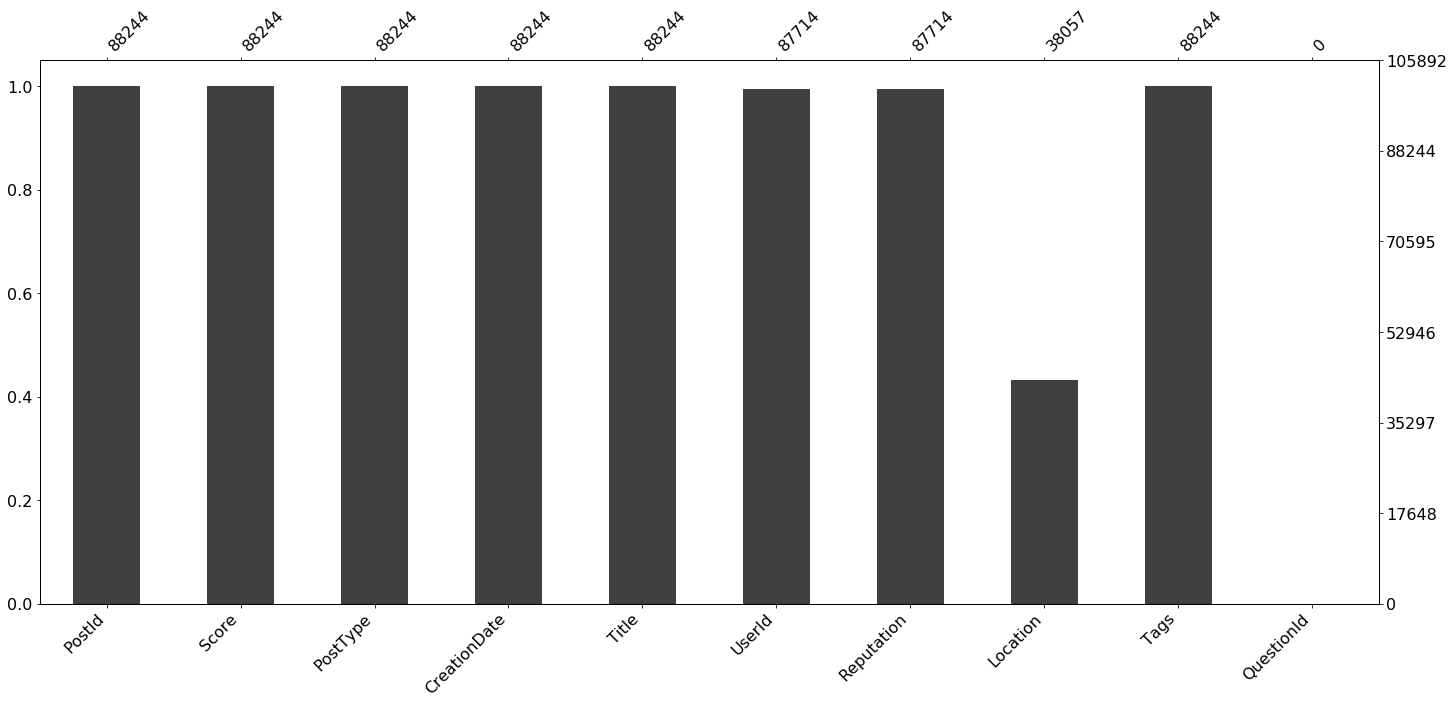

Answers


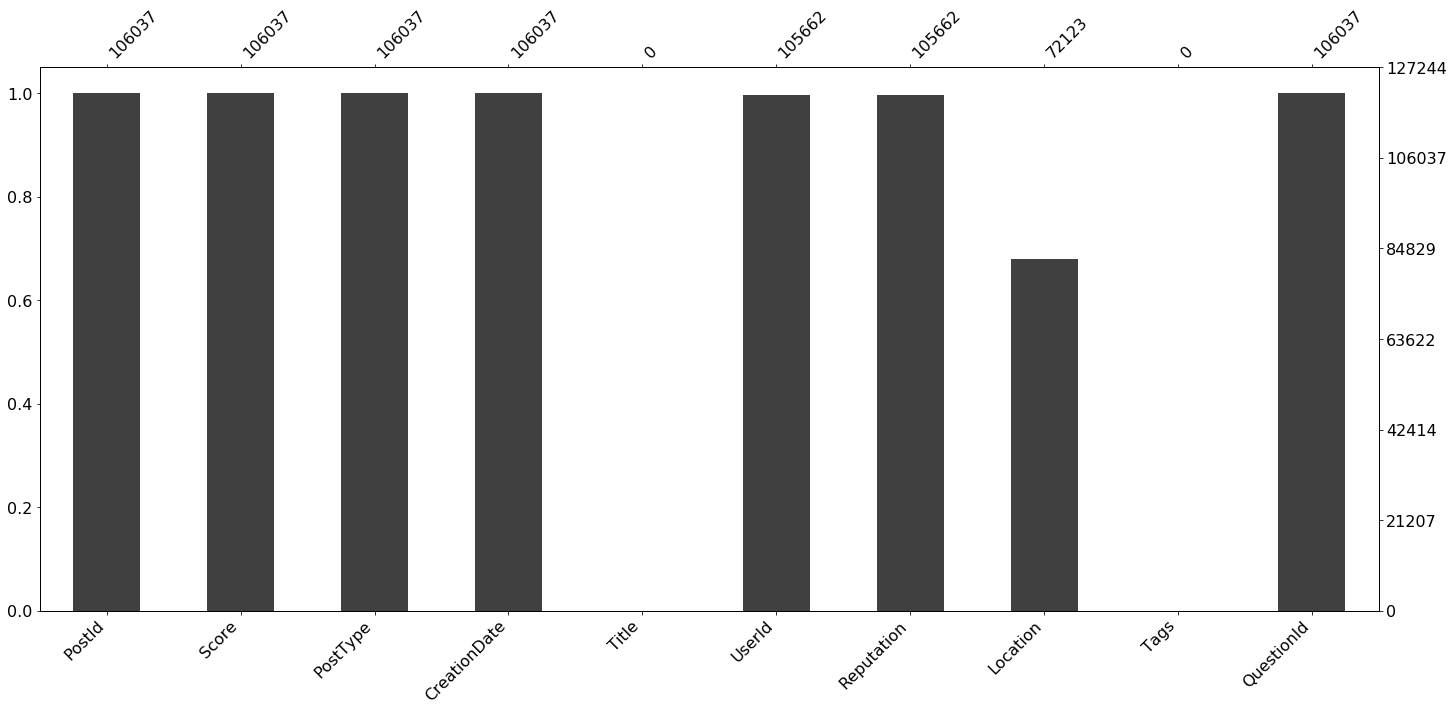

In [20]:
questions = posts[posts['PostType'] == 'Question']
answers = posts[posts['PostType'] == 'Answer']

print("Questions")
msno.bar(questions)
print("Answers")
msno.bar(answers)

Notice that UserId is missing for 1,171 questions and 785 answers. This is only .4% of the data overall, but it seems strange that a post can exist without a user to make it.

Usually, when you fing out that you having missing data you want to know why and what is going on with those points. Fortunately Pandas makes this very easy.

In [21]:
posts[posts['UserId'].isnull()].head()

,PostId,Score,PostType,CreationDate,Title,UserId,Reputation,Location,Tags,QuestionId
153,46018645,0,Question,2017-09-02 22:09:56,Android Get Application Start Up Path,NaN,NaN,NaN,<android><filesystems>,NaN
455,46014700,1,Question,2017-09-02 14:18:41,getting a result of a table Mysqli left join,NaN,NaN,NaN,<php><html><mysql><mysqli>,NaN
661,46016644,0,Question,2017-09-02 17:56:51,Load the .py file and display IPython interact...,NaN,NaN,NaN,<python><shell><ipython>,NaN
702,46014745,0,Question,2017-09-02 14:22:47,Show animation in queue using FFCircularProgre...,NaN,NaN,NaN,<ios><swift><animation>,NaN
722,46012773,0,Answer,2017-09-02 10:23:16,NaN,NaN,NaN,NaN,NaN,46012659.0


If we want to investigate these posts further, we can see posts and answers with null `UserId`s using Jupyter's HTML capabilities. The following code creates links we can click on to see each post on Stack Overflow. Compare the user descriptions for the linked posts to the user descriptions for other posts on the webpage.

In [22]:
def get_link(p, desc='has no UserId'):
    if p['PostType'] == 'Answer':
        link = '"https://stackoverflow.com/questions/{0}#answer-{1}"'.format(int(p['QuestionId']), int(p['PostId']))
        return '<a href='+link+' target="_blank">Answer {0} {1}</a>'.format(int(p['PostId']), desc)
    else:
        link = '"https://stackoverflow.com/questions/{0}"'.format(int(p['PostId']))
        return '<a href='+link+' target="_blank">Question {0} {1}</a>'.format(int(p['PostId']), desc)

display(HTML('<br/>'.join(posts[posts['UserId'].isnull()].head().apply(lambda p: get_link(p), axis=1))))

Did you notice that unlike other user descriptions, the users of the linked posts had no link to their profile page and no information about their reputation. My theory is that these users deleted their accounts.

<div id="time"></div>
## Visualizing Time
*[Table of Contents](#contents)*

1. What time of day do people post?
1. [How quickly were questions answered?](#firstReply)

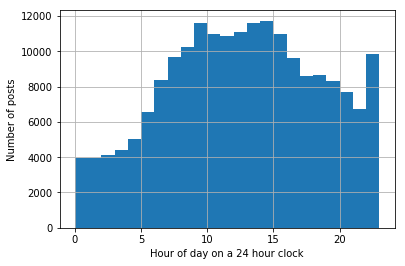

In [23]:
posts['CreationDate'].apply(lambda x: x.hour).hist(bins=range(24))
plt.xlabel('Hour of day on a 24 hour clock')
plt.ylabel('Number of posts')
plt.show()

Do you see anything odd in the distribution of when posts are created?

<div id="firstReply"></div>
How quickly were questions answered?

In [ ]:
# aggregate answers by question id
answers_by_question = answers.groupby('QuestionId')['CreationDate'].agg(min)
# get the earliest creation date for each answer
first_reply = pd.DataFrame({'PostId':answers_by_question.index.values, 'EarliestReply':answers_by_question.values})
# add the time of the earliest answer to the questions data frame (filtering out questions which were not answered)
first_reply = pd.merge(first_reply, questions, how='inner', on=['PostId'])

# get the time it took to get an answer
gap = (first_reply['EarliestReply']-first_reply['CreationDate'])
# convert to minutes
gap /= pd.Timedelta(minutes=1)

# find the median
print('Median answer time for questions asked and answered in September 2017 is {0} min.'.format(gap.median()))

To get a better idea of the distribution of question to answer latency, let's plot a histogram of this data. Since this distribution probably has a long tail, let's use a log scale.

In [ ]:
# Let's plot the data
plt.hist(gap.tolist(), bins = 50)
plt.yscale('log', nonposy='clip')
plt.ylabel('Number of Questions')
plt.xlabel('Time in Minutes')
plt.show()

Do you notice a particularly odd value in this chart?

How can we have an answer before the question was asked?

In [ ]:
weird_questions = first_reply[first_reply['EarliestReply'] < first_reply['CreationDate']]
links = weird_questions.apply(lambda p: get_link(p, desc='answered before question'), axis=1)
display(HTML('<br/>'.join(links)))

<div id="tags"></div>
## Visualize Tags
*[Table of Contents](#contents)*

How can we use wordclouds to explore tags as function of title keywords?

In [ ]:
def text_to_wordcloud(series, title):
    # stitch all the text together
    text = ' '.join(series.tolist())
    # make a wordcloud from the text
    title_wordcloud = wordcloud.WordCloud().generate(text)
    # we want the words in our cloud to all be the same color
    title_wordcloud.recolor(color_func=lambda word, **kwargs:'white')
    # turn the wordcloud into an image
    plt.imshow(title_wordcloud, interpolation='bilinear')
    # we don't want an x and y axis
    plt.axis("off")
    plt.title(title + ' (' + str(len(series)) + ' questions)')
    plt.show()

def get_tags(word):
    tags = questions[questions['Title'].str.lower().str.contains(word)]['Tags']
    tags = tags.apply(lambda x: x.strip('<>').split('><'))
    return tags

keyword_1 = 'data'
keyword_2 = 'fast'

group_1_tags = get_tags(keyword_1)
text_to_wordcloud(group_1_tags.apply(lambda x: ' '.join(x)), "Tags when '"+keyword_1+"' in question title")
group_2_tags = get_tags(keyword_2)
text_to_wordcloud(group_2_tags.apply(lambda x: ' '.join(x)), "Tags when '"+keyword_2+"' in question title")

Instead of using word clouds, let's try plotting the number of times a tag appears using a more traditional chart type.

In [ ]:
def get_tag_count(series):
    return pd.Series([t for tag_list in series for t in tag_list]).value_counts()

tag_counts = pd.concat([get_tag_count(group_1_tags), get_tag_count(group_2_tags)], axis=1)
tag_counts = tag_counts.rename(columns={0:keyword_1, 1:keyword_2})
tag_counts = tag_counts[tag_counts[keyword_1].notnull() & tag_counts[keyword_2].notnull()]

x = tag_counts[keyword_1].values
y = tag_counts[keyword_2].values
TOOLS = "pan,wheel_zoom,reset,hover,save"

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    group_1_perc=[round(val/len(group_1_tags)*100,2) for val in x],
    group_2_perc=[round(val/len(group_2_tags)*100,2) for val in y],
    name=tag_counts.index.tolist()
))

# uncomment the lines to switch this to a log scale to see the number for less popular languages
p = figure(
    title="Tags",
    tools=TOOLS,
#     x_axis_type="log",
#     y_axis_type="log",
    plot_height=400
)
p.circle('x', 'y', size=10, source=source)
p.xaxis.axis_label = "'"+keyword_1+"' in question title"
p.yaxis.axis_label = "'"+keyword_2+"' in question title"

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Tag", "@name"), ("% of '"+keyword_1+"' questions:", "@group_1_perc"), ("% of '"+keyword_2+"' questions:", "@group_2_perc")]

show(p)

According to this analysis what tag do people use when they are interested in looking at data quickly? Can you think of some other keywords that would be fun to plot against each other?

<div id="explore"></div>
## Text Visualization
*[Table of Contents](#contents)*

What is in the title of questions tagged 'python'?

One way of exploring this question is to use a word cloud

In [ ]:
python_titles = questions[questions['Tags'].str.contains('python')]['Title'].str.lower()
text_to_wordcloud(python_titles, "'Python' Tagged Questions")

### Other Methods of Looking at Word Frequencies

One problem with word clouds is that they divorce the words in them from any context. This isn't much of a problem when the words are tags, which aren't part of a sentence. But when looking at titles it would be nice to see what users are saying when they use the words 'python', 'using' and 'file'.

To really understand all 19,462 questions tagged 'python', we'd have to break out some machine learning methods, but their are ways visualize context better than a word cloud. One of them is called a [Word Tree](http://hint.fm/papers/wordtree_final2.pdf) and was developed by the many eyes group at IBM. You can see [examples](https://www.jasondavies.com/wordtree/) of this style of visualization made in d3.js.

Since Jupyter notebooks can embed HTML elements, word trees rendered in d3 can be embedded in a notebook. However, for this tutorial we are sticking to python, so I will demonstrate how to build a word tree using a library which runs [graphviz](http://graphviz.org) in python.

In [ ]:
# a variable to help us mark nodes as distinct when they have the same label
node_counter = 0

# a class to keep track of a node and it's connections
class Node:
    def __init__(self, word, count, matching_strings, graph, reverse=False, branching=3, highlight=False):
        global node_counter
        if highlight:
            self.node = graphviz.Node(node_counter, label=word+'\n'+str(count), peripheries=2, fontsize=20)
        else:
            self.node = graphviz.Node(node_counter, label=word+'\n'+str(count))
        node_counter += 1
        graph.add_node(self.node)
        if count > 1:
            self.generate_children(matching_strings, graph, reverse, branching)
    
    def generate_children(self, matching_strings, graph, reverse, branching):
        if len(matching_strings) == 0:
            return
        matching_strings = matching_strings[matching_strings.apply(len) > 0]
        all_children = Counter(matching_strings.apply(lambda x:x[-1 if reverse else 0]))
        children = all_children.most_common(branching)
        for word, count in children:
            if not reverse:
                child_matches = matching_strings[matching_strings.apply(lambda x:x[0]) == word].apply(lambda x:x[1:])
                c_node = Node(word, count, child_matches, graph=graph, reverse=reverse, branching=branching)
                graph.add_edge(graphviz.Edge(self.node, c_node.node))
            else:
                child_matches = matching_strings[matching_strings.apply(lambda x:x[-1]) == word].apply(lambda x:x[:-1])
                c_node = Node(word, count, child_matches, graph=graph, reverse=reverse, branching=branching)
                graph.add_edge(graphviz.Edge(c_node.node, self.node))
        left_over = sum(all_children.values()) - sum([x[1] for x in children])
        if left_over > 0:
            c_node = Node('...', left_over, [], graph=graph, reverse=reverse, branching=branching)
            if reverse:
                graph.add_edge(graphviz.Edge(c_node.node, self.node))
            else:
                graph.add_edge(graphviz.Edge(self.node, c_node.node))

def build_tree(root_string, suffixes, prefixes):
    graph = graphviz.Dot()
    root = Node(root_string, len(suffixes), suffixes, graph, reverse=False, highlight=True)
    root.generate_children(prefixes, graph, True, 3)
    return Image(graph.create_png())

def get_end(string, sub_string, reverse):
    side = 0 if reverse else -1
    return [x for x in re.split(r'[^\w]+', string.lower().split(sub_string)[side]) if len(x) > 0]

def select_text(phrase):
    series = questions['Title']
    instances = series[series.str.lower().str.contains(phrase)]
    suffixes = instances.apply(lambda x: get_end(x, phrase, False))
    prefixes = instances.apply(lambda x: get_end(x, phrase, True))
    return build_tree(phrase, suffixes, prefixes)

select_text('file using python')

We can use our word tree function to explore how any phrase is used in question titles

In [ ]:
select_text('tableau')

<div id="place"></div>
## Plot Places
*[Table of Contents](#contents)*

Where do people say they are from?

In this example we'll look at how to make maps in python and why making maps is so hard.

Let's start by adding information on each location from the [Google Maps API](https://developers.google.com/maps/).

In [ ]:
location_data = pd.read_csv('loc_data.csv')
location_data['Google_Data'] = location_data['Google_Data'].apply(lambda x: eval(x))

location_data['Google_Data'].apply(len).hist()
#plt.yscale('log', nonposy='clip')
plt.xlabel('Number of Matches')
plt.ylabel('Number of Unique Place Strings')
plt.show()

location_data = location_data[location_data['Google_Data'].apply(len) == 1]
posts_with_location = pd.merge(posts, location_data, how='inner', on='Location')

How precise is our location information?

In [ ]:
def get_lowest_component(address_list):
    components = address_list[0]['address_components']
    all_parts = []
    for c in components:
        if len(c['types']) == 2 and c['types'][1] == 'political':
            all_parts.append(c['types'][0])
    if len(all_parts) > 0:
        return all_parts[0]
    return None

posts_with_location = pd.merge(posts, location_data, how='inner', on='Location')
lowest_components = posts_with_location['Google_Data'].apply(get_lowest_component).value_counts()
lowest_components.plot(kind='bar', color='DarkBlue')
plt.show()

Let's add information on each level of location we have available

In [ ]:
def get_part(address_list, level='country', name_type='long_name'):
    components = address_list[0]['address_components']
    for c in components:
        if c['types'] == [level, 'political']:
            return c[name_type]
    return None

for part in lowest_components.index:
    print(part)
    posts_with_location[part] = posts_with_location['Google_Data'].apply(lambda x: get_part(x, level=part))

posts_with_location.head()

One way to plot location is to just make a convex hull around each set of latitude and longitude points

In [ ]:
def get_lat_long(address_list):
    location = address_list[0]['geometry']['location']
    return location['lat'], location['lng']

posts_with_location['lat_lng'] = posts_with_location['Google_Data'].apply(get_lat_long)
posts_with_location['lat'] = posts_with_location['lat_lng'].apply(lambda x: x[0])
posts_with_location['lng'] = posts_with_location['lat_lng'].apply(lambda x: x[1])
msno.geoplot(posts_with_location, x='lng', y='lat', by='country')

Let's make a better map.

In order to make a better map we need shape files which contain information on the boundries of each area we are interested in. We also need to link our data to these shape files which is usually far from trivial. In this example we will plot US counties because shape files on US states and counties are easy to find.

I don't go over map projections here, but the projection of a map can be changed fairly easily. Shape files contain border information in latitude and longitude typically. You can write a projection function which can be applied to each cordinate before the map is plotted to capture the fact that the world is not square.

In [ ]:
county_posts = posts_with_location.loc[posts_with_location['country'] == 'United States',:]
county_posts = county_posts.groupby(['administrative_area_level_1', 'administrative_area_level_2'])

def get_lang_count(series, lang='python'):
    return len(series[series.notnull() & (series.str.find('<'+lang+'>') > -1)])

county_stats = county_posts.agg({'lat':np.mean, 'lng':np.mean, 'PostId':len, 'Tags':get_lang_count,
                                'PostType':lambda x : len(x[x=='Question'])})

county_stats.reset_index(inplace=True)
county_stats = county_stats.rename(columns={'PostId':'posts', 'Tags':'python questions', 'PostType':'questions', 'administrative_area_level_1':'State', 'administrative_area_level_2':'County'})
county_stats.head()

In [ ]:
# get shape date for counties and states
counties = {
    code: county for code, county in counties.items()
}

us_states = us_states_data.data.copy()

name_to_code = dict([(counties[code]['detailed name'], code) for code in counties])

def match_county(county):
    state = county['State']
    county_name = county['County']
    # take out non-ascii characters which are not in Bokeh file
    county_name = unicodedata.normalize('NFKD', county_name).encode('ascii','ignore').decode("utf-8")
    full_name = county_name + ', ' + state
    if full_name in name_to_code:
        return name_to_code[full_name]
    close_matches = [n for n in name_to_code.keys() if n.endswith(state) and n.startswith(county_name.split(' ')[0])]
    if len(close_matches) == 0:
        print(full_name)
        return None
    full_name = min(close_matches, key=len)
    return name_to_code[full_name]

county_stats['code'] = pd.Series(county_stats.apply(match_county, axis=1))
county_stats.head()

In [ ]:
def build_map(county_stats, county_slice=None, language='python'):
    color_mapper = LogColorMapper(palette=palette)
    
    if county_slice is not None:
        county_stats = county_stats[county_slice]

    county_xs = county_stats['code'].apply(lambda code: counties[code]["lons"]).tolist()
    county_ys = county_stats['code'].apply(lambda code: counties[code]["lats"]).tolist()
    county_names = (county_stats["County"]+', '+county_stats["State"]).tolist()
    
    language_perc = county_posts['Tags'].agg(lambda x: get_lang_count(x, language))
    language_perc = language_perc.reset_index()
    if county_slice is not None:
        language_perc = language_perc[county_slice]
    language_perc = (language_perc['Tags']/county_stats['questions'])
    language_perc = (language_perc*100).tolist()

    posts_source = ColumnDataSource(data=dict(
        x=county_xs,
        y=county_ys,
        name=county_names,
        posts=county_stats['posts'].tolist(),
        questions=county_stats['questions'].tolist(),
        lang_posts=language_perc
    ))
    
    TOOLS = "pan,wheel_zoom,reset,save"

    p = figure(
        title="Posts by County", tools=TOOLS,
        x_axis_location=None, y_axis_location=None,
        plot_width=900
    )
    p.grid.grid_line_color = None

    county_pathches = Patches(xs="x", ys="y",
              fill_color={'field': 'lang_posts', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)
    county_pathches_render = p.add_glyph(posts_source, county_pathches)
    
    # add hover tooltip
    hover = HoverTool(renderers=[county_pathches_render], tooltips=[
        ("Name", "@name"),
        ("Posts", "@posts"),
        ("Questions", "@questions"),
        ("% "+language.capitalize(), "@lang_posts")])
    p.add_tools(hover)
    
    # -----------
    # Add state outlines
    # -----------
    filter_fun = lambda x : x != 'AK' and x != 'HI'
    # get lat and long as x and y
    state_xs = [us_states[code]["lons"] for code in us_states if filter_fun(code)]
    state_ys = [us_states[code]["lats"] for code in us_states if filter_fun(code)]
    
    # draw state lines
    p.patches(state_xs, state_ys, fill_alpha=0.0, line_color="#"+('9'*6), line_width=0.5)

    show(p)

build_map(county_stats)

In [ ]:
build_map(county_stats, county_stats['posts'] > 30, language='python')

<div id="network"></div>
## Plot Connections
*[Table of Contents](#contents)*

We can model user interactions as a graph by making an edge from each person who answers a question to the person who posted that question. We can then use graphviz to visualize this graph.

To start with, we need to compute the edges between non-null users.

In [ ]:
# filter out null users and get question ids
from_edges = answers.loc[answers['UserId'].notnull(),['UserId', 'QuestionId']]
from_edges.rename(columns={'UserId':'AnswerUID', 'QuestionId':'PostId'}, inplace=True)
# filter out null users and get question ids
to_edges = questions.loc[questions['UserId'].notnull(),['UserId','PostId']]
# merge on question id
links = pd.merge(from_edges, to_edges, on='PostId', how='inner')
# use a counter to merge duplicate edges to get edge weights
edges = Counter(links.apply(lambda x:(x['AnswerUID'], x['UserId']), axis=1).tolist())
edges.most_common(10)

Let's use user reputation to color the nodes in our graph.

In [ ]:
repuatation_map = dict(zip(posts['UserId'], posts['Reputation']))

Let's make some functions to visualize our graph.

Graphviz has a few algorithms for deciding where nodes go. You can choose between them use the `prog` attribute when you create the graph image. The default option is dot, which works well for trees, but makes less sense for visualizing social networks. The full list of options is:
* dot - "hierarchical" or layered drawings of directed graphs. This is the default tool to use if edges have directionality.
* neato - "spring model'' layouts.  This is the default tool to use if the graph is not too large (about 100 nodes) and you don't know anything else about it. Neato attempts to minimize a global energy function, which is equivalent to statistical multi-dimensional scaling.
* fdp - "spring model'' layouts similar to those of neato, but does this by reducing forces rather than working with energy.
* twopi - radial layouts, after Graham Wills 97. Nodes are placed on concentric circles depending their distance from a given root node.
* circo - circular layout, after Six and Tollis 99, Kauffman and Wiese 02. This is suitable for certain diagrams of multiple cyclic structures, such as certain telecommunications networks.

In this example, nodes don't have labels and are filled according to a user's repuatation. If you would like to label nodes with the user's id, just change `label=''` to `label=uid` in `make_node`. In this example darker colors signify user's with less reputation. To change this just add `val = 255 - val` in `get_fill`. I like magenta, but if you want a different overall color to the graph, change the return statement for `get_fill`. These are some simple options:
* gray = [val, val, val]
* red = [val, 0, 0]
* green = [0, val, 0]
* blue = [0, 0, val]
* yellow = [val, val, 0]
* cyan = [0, val, val]

In [ ]:
# a function to get a fill color based on reputation
def get_fill(uid):
    rep = repuatation_map[int(uid)]
    # The distribution of reputations is very lop-sided, so let's use log reputation for our scale
    # the value should be between 0 and 255
    val = np.log(rep)/np.log(max(repuatation_map.values())) * 255
    return to_hex([val, 0, val])

# turn a RGB triplet into a hex color graphviz will understand
def to_hex(triple):
    output = '#'
    for val in triple:
        # the hex funciton returns a string of the form 0x<number in hex>
        val = hex(int(val)).split('x')[1]
        if len(val) < 2:
            val = '0'+val
        output += val
    return output

# The function to visualize our network graph
# It takes in a list of edges with weights
def build_network(edges_with_weights, prog='neato'):
    # The function which builds each node. You can change the node style here.
    make_node = lambda uid: graphviz.Node(uid, label='', shape='circle', style='filled', fillcolor=get_fill(uid), color='white')
    graph = graphviz.Dot()
    # A dictionary to keep track of node objects
    nodes = {}
    for pair in edges_with_weights:
        e, w = pair
        e = (str(int(e[0])), str(int(e[1])))
        # Add notes to the graph if they don't exist yet
        if e[0] not in nodes:
            nodes[e[0]] = make_node(e[0])
            graph.add_node(nodes[e[0]])
        if e[1] not in nodes:
            nodes[e[1]] = make_node(e[1])
            graph.add_node(nodes[e[1]])
        graph.add_edge(graphviz.Edge(nodes[e[0]], nodes[e[1]], penwidth=(float(w)/2)))
    return Image(graph.create_png(prog=prog))

# Let's build a small network from the edges with the highest weights.
build_network(edges.most_common(10))

Notice that a two of the ten highest weighted edges are self loops. Who are the students who answer their own questions so many times and what are the questions where they post and answer?

In [ ]:
[x for x in edges.most_common(10) if x[0][0] == x[0][1]]

In [ ]:
uid = 4058737
self_links = links.loc[(links['AnswerUID'] == uid) & (links['UserId'] == uid),:].copy()
self_links['PostType'] = 'Question'
display(HTML('<br/>'.join(self_links.apply(lambda p: get_link(p, 'is a self link'), axis=1))))

As we can see from the sample of edges above, this may not be a connected graph. Let's pick a sample of edges and plot a connected subgraph.

In [ ]:
def find_connected_subgraphs(edges):
    nodes = list(set([n for e in edges for n in e]))
    mappings = dict(zip(nodes, range(len(nodes))))
    flipped_mappings = dict(zip(range(len(nodes)), [[n] for n in nodes]))
    for e in edges:
        c_1 = mappings[e[0]]
        c_2 = mappings[e[1]]
        if c_1 == c_2:
            continue
        if len(flipped_mappings[c_1]) > len(flipped_mappings[c_2]):
            tmp = c_1
            c_1 = c_2
            c_2 = tmp
        for n in flipped_mappings[c_1]:
            mappings[n] = c_2
            flipped_mappings[c_2].append(n)
    return mappings

num_edges = 10000
connection_mapping = find_connected_subgraphs([x[0] for x in edges.most_common(num_edges)])
Counter(connection_mapping.values()).most_common(10)

The list above gives an identification number for a connected subgraph and the number of nodes which are in that subgraph.

100 nodes seems like a large enough graph.

*Note: If you plot a graph with over 500 nodes you might overwhelm graphviz*

In [ ]:
subgraph_id_number = 3586
e_list = [x for x in edges.most_common(num_edges) if connection_mapping.get(x[0][0],None) == subgraph_id_number]
build_network(e_list)

<div id="conclusion"></div>
## Conclusion
*[Table of Contents](#contents)*

Hopefully this tutorial tought you something new about visualization in python. Some key points I'd like to highlight are:

1. visualize early - making visualizations early on can help a lot with data cleaning
1. visualize for yourself first - visualization is a powerful tool for showing you what is going on in your data and if you can't understand your own visualizations, no one else will
1. barcharts are awesome, but not everything should be a barchart - wordtrees, network diagrams and heatmaps are also nice